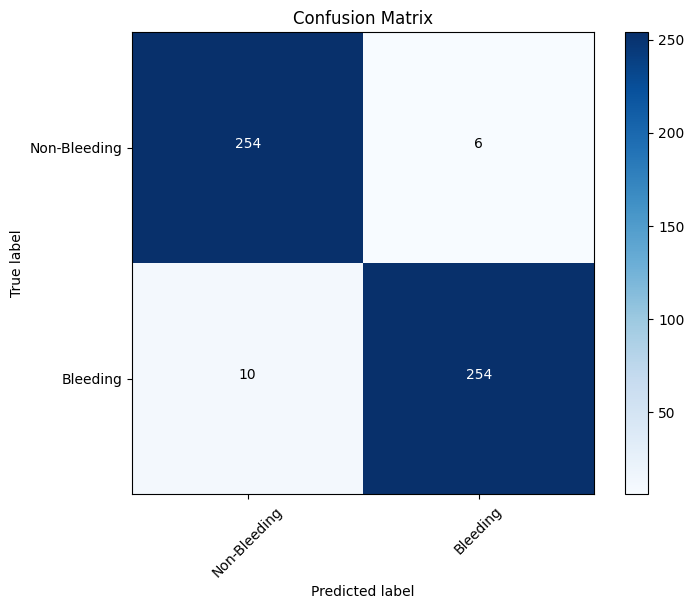

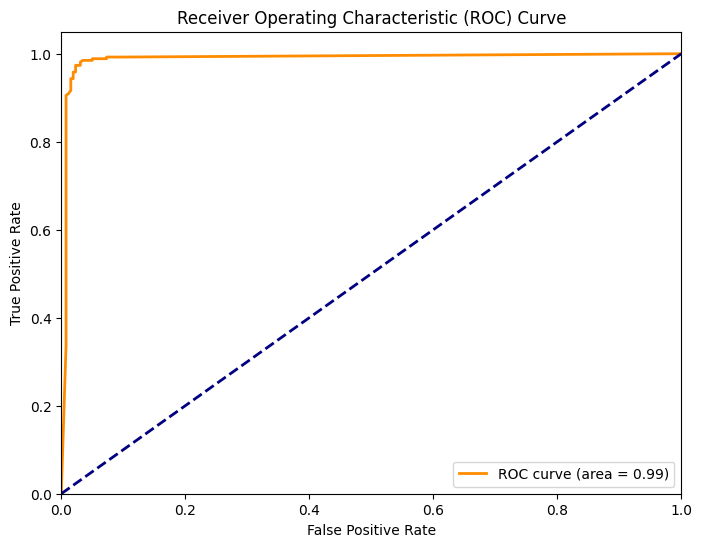

Accuracy: 0.9694656488549618
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       260
           1       0.98      0.96      0.97       264

    accuracy                           0.97       524
   macro avg       0.97      0.97      0.97       524
weighted avg       0.97      0.97      0.97       524



In [1]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import itertools

def load_images(folder_path):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):

            img = Image.open(os.path.join(folder_path, filename))
            
            # Convert the image to a numpy array
            img_array = np.array(img).flatten()
            
            images.append(img_array)

            label = 1 if "bleeding" in filename else 0  # If image is bleeding then we assign label as 1 otherwise we assign 0
            labels.append(label)

    return np.array(images), np.array(labels)

dataset_folder = './DatsetForUse'
X, y = load_images(dataset_folder)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create individual base models
base_models = [
    ('svm', LogisticRegression(random_state=42, max_iter=1000)),
    ('nb', GaussianNB()),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
]

# Create a meta-model
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create the stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Training the stacking classifier and prediting the values
stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Non-Bleeding', 'Bleeding']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.ylabel('True label')
plt.xlabel('Predicted label')

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.show()

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, stacking_clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_result)
